<a href="https://colab.research.google.com/github/Elfeny7/ComputerVision_Learn/blob/main/Human_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2 as cv
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
import os
import gdown
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [11]:
directory = '/content/drive/My Drive/PCVK'

yolov3w = f'{directory}/yolov3-tiny.weights'
yolov3c = f'{directory}/yolov3-tiny.cfg'
cn = f'{directory}/coco.names'

In [5]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/

In [6]:
!pip install kaggle

In [7]:
!kaggle datasets download -d constantinwerner/human-detection-dataset

100% 259M/260M [00:01<00:00, 173MB/s]
100% 260M/260M [00:01<00:00, 153MB/s]


In [8]:
with zipfile.ZipFile('human-detection-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

In [9]:
# Definisikan path dataset
dataset_path = "dataset/human detection dataset"

# Definisikan parameter untuk data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Menentukan persentase data untuk validasi
)

# Load seluruh dataset dengan pembagian data validasi
generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary'
)

# Membangun model CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(64, 64, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Latih model
history = model.fit(generator, epochs=10)

# Simpan model
model.save('human_detection_model.h5')

Found 921 images belonging to 2 classes.
Epoch 1/10
29/29 [==============================] - 22s 339ms/step - loss: 0.6766 - accuracy: 0.5961
Epoch 2/10
29/29 [==============================] - 10s 349ms/step - loss: 0.6583 - accuracy: 0.6363
Epoch 3/10
29/29 [==============================] - 9s 319ms/step - loss: 0.6496 - accuracy: 0.6428
Epoch 4/10
29/29 [==============================] - 11s 360ms/step - loss: 0.6432 - accuracy: 0.6504
Epoch 5/10
29/29 [==============================] - 11s 388ms/step - loss: 0.6390 - accuracy: 0.6504
Epoch 6/10
29/29 [==============================] - 11s 375ms/step - loss: 0.6344 - accuracy: 0.6580
Epoch 7/10
29/29 [==============================] - 10s 354ms/step - loss: 0.6292 - accuracy: 0.6612
Epoch 8/10
29/29 [==============================] - 10s 336ms/step - loss: 0.6149 - accuracy: 0.6819
Epoch 9/10
29/29 [==============================] - 8s 286ms/step - loss: 0.6145 - accuracy: 0.6775
Epoch 10/10
29/29 [==============================] -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Ada manusia dalam gambar.


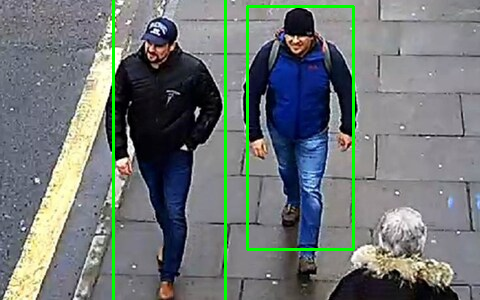

Jumlah manusia: 2


In [14]:
# Fungsi untuk deteksi manusia menggunakan YOLO
def detect_and_count_humans(image_path):
    # Load model YOLO (contoh menggunakan YOLOv3)
    net = cv.dnn.readNet(yolov3w, yolov3c)

    # Baca gambar
    image = cv.imread(image_path)
    height, width = image.shape[:2]

    # Konversi gambar ke format blob yang digunakan oleh YOLO
    blob = cv.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)

    # Set input ke model YOLO
    net.setInput(blob)

    # Jalankan deteksi objek
    layer_names = net.getUnconnectedOutLayersNames()
    outputs = net.forward(layer_names)

    # Inisialisasi list untuk menyimpan koordinat manusia yang terdeteksi
    human_coordinates = []

    for output in outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > 0.5 and class_id == 0:  # Class_id 0 adalah manusia
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Hitung koordinat sudut kotak
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                human_coordinates.append((x, y, x + w, y + h))

    # Hitung jumlah manusia dalam gambar
    count = len(human_coordinates)

    # Tampilkan teks "Ada manusia" atau "Tidak ada manusia" berdasarkan hasil deteksi
    if count > 0:
        print("Ada manusia dalam gambar.")
    else:
        print("Tidak ada manusia dalam gambar.")

    # Tampilkan gambar dengan kotak presisi
    for (x1, y1, x2, y2) in human_coordinates:
        cv.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Tampilkan gambar dengan kotak dan teks
    cv2_imshow(image)
    cv.waitKey(0)
    cv.destroyAllWindows()

    return count

# Contoh pengujian gambar
image_path = "sad.jpeg"  # Ganti dengan path gambar yang ingin Anda uji
jumlah_manusia = detect_and_count_humans(image_path)
print("Jumlah manusia:", jumlah_manusia)
